# High Dimensional Weighted Gene Correlation Network Analysis (hdWGCNA)

**Authorship:**
Adam Klie, *08/24/2022*
***
**Description:**
Notebook to run a WGCNA on stimulated pancreatic islet multiome data (well just the RNA)
***

In [2]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# network analysis & visualization package:
library(igraph)

# packages for TF motif analysis
library(JASPAR2020)
library(motifmatchr)
library(TFBSTools)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)

# TestGeneOverlap
library(GeneOverlap)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is

In [3]:
# Parameters
CELL.TYPES <- "beta"  # Meaning α, β, δ in this context
ASSAY <- "RNA"
NORMALIZATION <- "ND"
NN <- 25
GENES <- "all"

In [4]:
# File names for saving
NAME=paste0(CELL.TYPES, "cells_", GENES, "genes_", NORMALIZATION, "_", NN, "neighbors")
OUT= file.path("./motif_analysis", NAME)
OUT

[1] "./motif_analysis/betacells_allgenes_ND_25neighbors"

In [5]:
# load the preprocessed RDS from 1_network_construction.ipynb
seurat_obj <- readRDS(sprintf('network_construction/%s_hdWGCNA.rds', NAME))

In [6]:
# get the pfm from JASPAR2020 using TFBSTools
pfm_core <- TFBSTools::getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

In [7]:
MotifScan <- function(
  seurat_obj,
  species_genome, # hg38, mm10, etc...
  pfm, # matrix set from JASPAR2020 for example
  EnsDb, # Ensembl database such as EnsDb.Mmusculus.v79
  wgcna_name=NULL
){

  if(is.null(wgcna_name)){wgcna_name <- seurat_obj@misc$active_wgcna}

  # get a dataframe of just the motif name and the motif ID:
  motif_df <- data.frame(
    motif_name = purrr::map(1:length(pfm), function(i){pfm[[i]]@name}) %>% unlist,
    motif_ID = purrr::map(1:length(pfm), function(i){pfm[[i]]@ID}) %>% unlist
  )

  # get promoters of protein coding genes from the given Ensdb
  # note: everything breaks if I try to use X & Y chromosomes.
  gene.promoters <- ensembldb::promoters(EnsDb, filter = ~ gene_biotype == "protein_coding") %>%
    subset(seqnames %in% c(1:100))
  gene.coords <- ensembldb::genes(EnsDb, filter = ~ gene_biotype == "protein_coding") %>%
    subset(seqnames %in% c(1:100))

  # add the gene name to the promoter object
  gene.promoters$symbol <- gene.coords$symbol[match(gene.promoters$gene_id, names(gene.coords))]

  # drop unnecessary chromosomes
  gene.promoters <- keepSeqlevels(gene.promoters, value= levels(droplevels(seqnames(gene.promoters))))

  # rename seqlevels to add 'chr', remove X&Y chromosomes because they break everything
  old_levels <- levels(seqnames(gene.promoters))
  new_levels <- ifelse(old_levels %in% c('X', 'Y'), old_levels, paste0('chr', old_levels))
  gene.promoters <- renameSeqlevels(gene.promoters, new_levels)

  # set the genome (not sure if we NEED to do this...)
  genome(seqinfo(gene.promoters)) <- species_genome

  # set up promoters object that only has the necessary info for motifmatchr
  my_promoters <- GRanges(
    seqnames =  droplevels(seqnames(gene.promoters)),
    IRanges(
      start = start(gene.promoters),
      end = end(gene.promoters)
    ),
    symbol = gene.promoters$symbol,
    genome=species_genome
  )

  # scan these promoters for motifs:
  print('Matching motifs...')
  motif_ix <- motifmatchr::matchMotifs(pfm, my_promoters, genome=species_genome)

  # get the matches
  tf_match <- motifmatchr::motifMatches(motif_ix)
  rownames(tf_match) <- my_promoters$symbol

  # use motif names as the column names:
  colnames(tf_match) <- motif_df$motif_name

  # only keep genes that are in the Seurat object and in the given EnsDb:
  gene_list <- rownames(seurat_obj)
  gene_list <- gene_list[gene_list %in% rownames(tf_match)]
  tf_match <- tf_match[gene_list,]

  # get list of target genes for each TF:
  print('Getting TF target genes...')
  tfs <- motif_df$motif_name
  tf_targets <- list()
  n_targets <- list()
  for(cur_tf in tfs){
    tf_targets[[cur_tf]] <- names(tf_match[,cur_tf][tf_match[,cur_tf]])
    n_targets[[cur_tf]] <- length(tf_targets[[cur_tf]] )
  }
  n_targets <- unlist(n_targets)

  # add number of target genes to motif df
  motif_df$n_targets <- n_targets

  # add info to seurat object
  seurat_obj <- SetMotifMatrix(seurat_obj, tf_match)
  seurat_obj <- SetMotifs(seurat_obj, motif_df)
  seurat_obj <- SetMotifTargets(seurat_obj, tf_targets)
  seurat_obj <- SetPFMList(seurat_obj, pfm)

  seurat_obj
}

In [8]:
# run the motif scan with these settings for the mouse dataset
seurat_obj <- MotifScan(
  seurat_obj,
  EnsDb = EnsDb.Hsapiens.v86,
  species_genome = 'hg38',
  pfm = pfm_core
)
dim(GetMotifMatrix(seurat_obj))

[1] "Matching motifs..."



Attaching package: 'XVector'


The following object is masked from 'package:purrr':

    compact



Attaching package: 'Biostrings'


The following object is masked from 'package:base':

    strsplit



Attaching package: 'rtracklayer'


The following object is masked from 'package:igraph':

    blocks




[1] "Getting TF target genes..."


[1] 17816   746

In [9]:
# TF target genes
target_genes <- GetMotifTargets(seurat_obj)

# check target genes for one TF:
head(target_genes$SOX9)

[1] "OR4F5"  "TTLL10" "SDF4"   "ATAD3C" "MIB2"   "CDK11B"

In [13]:
# overlap between modules & TF target genes:
seurat_obj<- OverlapModulesMotifs(seurat_obj)

# look at the overlap data
head(GetMotifOverlap(seurat_obj))

,module,tf,color,odds_ratio,pval,fdr,Significance,Jaccard,size_intersection
,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Arnt,betacells_allgenes_ND_25neighbors-M1,Arnt,turquoise,3.140330,4.178998e-190,1.320988e-188,***,0.16134089,1338
Ahr::Arnt,betacells_allgenes_ND_25neighbors-M1,Ahr::Arnt,turquoise,2.995917,1.048250e-207,3.688654e-206,***,0.17209639,1664
Ddit3::Cebpa,betacells_allgenes_ND_25neighbors-M1,Ddit3::Cebpa,turquoise,2.968547,2.357045e-149,5.360840e-148,***,0.14373128,1104
Mecom,betacells_allgenes_ND_25neighbors-M1,Mecom,turquoise,1.817413,3.808247e-48,3.074624e-47,***,0.11277683,993
FOXF2,betacells_allgenes_ND_25neighbors-M1,FOXF2,turquoise,1.682532,3.344493e-32,1.928124e-31,***,0.09880750,812
FOXD1,betacells_allgenes_ND_25neighbors-M1,FOXD1,turquoise,1.576346,7.673277e-20,3.252423e-19,***,0.08060351,593


In [14]:
#' Displays the top n TFs in a set of modules as a bar plot
#'
#' @param seurat_obj A Seurat object
#' @param wgcna_name The name of the hdWGCNA experiment in the seurat_obj@misc slot
#' @keywords scRNA-seq
#' @export
#' @examples
#' MotifOverlapBarPlot
MotifOverlapBarPlot <- function(
  seurat_obj,
  n_tfs = 10,
  plot_size = c(5,6),
  outdir = "MotifOverlaps/",
  motif_font = 'helvetica_regular',
  module_names = NULL,
  wgcna_name=NULL
){

  if(is.null(wgcna_name)){wgcna_name <- seurat_obj@misc$active_wgcna}

  # make output dir if it doesn't exist:
  if(!dir.exists(outdir)){dir.create(outdir)}

  # get Modules
  modules <- GetModules(seurat_obj)
  mods <- levels(modules$module)
  mods <- mods[mods != 'grey']

  if(is.null(module_names)){module_names <- mods}

  # get overlap info from Seurat obj
  overlap_df <- GetMotifOverlap(seurat_obj, wgcna_name)
  motif_df <- GetMotifs(seurat_obj)

  # get pfm list from Seurat obj
  pfm <- GetPFMList(seurat_obj)

  # add motif ID to the overlap_df
  overlap_df$motif_ID <- motif_df$motif_ID[match(overlap_df$tf, motif_df$motif_name)]

  # subset by the modules that we are using:
  overlap_df <- overlap_df %>% subset(module %in% module_names)

  for(cur_mod in module_names){
    print(cur_mod)
    # get df for cur mod
    plot_df <- overlap_df %>% subset(module == cur_mod) %>% top_n(n_tfs, wt=odds_ratio) %>%
      arrange(desc(odds_ratio))

    # make the barplot
    p1 <- plot_df %>% ggplot(aes(y=reorder(tf, odds_ratio), fill=odds_ratio, x=odds_ratio)) +
      geom_bar(stat='identity', width=0.7) + NoLegend() +
      scale_fill_gradient(high=unique(plot_df$color), low='grey90') +
      ylab('') + theme(
        axis.line.y = element_blank(),
        axis.text.y = element_blank(),
        plot.margin = margin(
          t = 0, r = 0, b = 0, l = 0
        )
      )

    # make the motif logo plots:
    plot_list <- list()
    for(i in 1:nrow(plot_df)){
      cur_id <- plot_df[i,'motif_ID']
      cur_name <- plot_df[i,'tf']
      plot_list[[cur_id]] <- ggplot() +
        ggseqlogo::geom_logo( as.matrix(pfm[[cur_id]]), font=motif_font) +
        ggseqlogo::theme_logo() +
        xlab('') + ylab(cur_name) + theme(
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.title.y = element_text(angle=0),
          plot.margin = margin(t = 0,  # Top margin
                                 r = 0,  # Right margin
                                 b = 0,  # Bottom margin
                                 l = 0) # Left margin
        )
    }

    # wrap the motif logos
    patch1 <- wrap_plots(plot_list, ncol=1)

    # assemble the plot with patchwork
    outplot <- (patch1 | p1) +
          plot_layout(ncol=2, widths=c(1,2)) +
          plot_annotation(title=paste0('Motif overlaps with ', cur_mod),
          theme = theme(plot.title=element_text(hjust=0.5))
        )

    pdf(paste0(outdir, '/', cur_mod, '_motif_overlaps.pdf'), width=plot_size[1], height=plot_size[2], useDingbats=FALSE)
    print(outplot)
    dev.off()

  }

}

In [15]:
# plot the top TFs overlapping with
MotifOverlapBarPlot(
  seurat_obj,
  #motif_font = 'xkcd_regular',
  outdir = 'motif_analysis/MotifOverlaps/',
  plot_size=c(5,6)
)

[1] "betacells_allgenes_ND_25neighbors-M1"


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = F

[1] "betacells_allgenes_ND_25neighbors-M2"


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = F

[1] "betacells_allgenes_ND_25neighbors-M3"


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = F

[1] "betacells_allgenes_ND_25neighbors-M4"


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = F

[1] "betacells_allgenes_ND_25neighbors-M5"


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."
Warning message:
"`guides(<scale> = F

In [15]:
seurat_obj <- MotifTargetScore(
  seurat_obj
)

Loading required package: Signac



In [17]:
table(seurat_obj@misc$allcells_allgenes_ND_25neighbors$wgcna_modules$color, seurat_obj@misc$allcells_allgenes_ND_25neighbors$wgcna_modules$module)

             
              grey allcells_allgenes_ND_25neighbors-M1
  black          0                                   0
  blue           0                                   0
  brown          0                                   0
  green          0                                   0
  greenyellow    0                                   0
  grey        5092                                   0
  magenta        0                                   0
  pink           0                                   0
  purple         0                                   0
  red            0                                   0
  turquoise      0                                4274
  yellow         0                                   0
             
              allcells_allgenes_ND_25neighbors-M2
  black                                         0
  blue                                          0
  brown                                         0
  green                                         0
  green

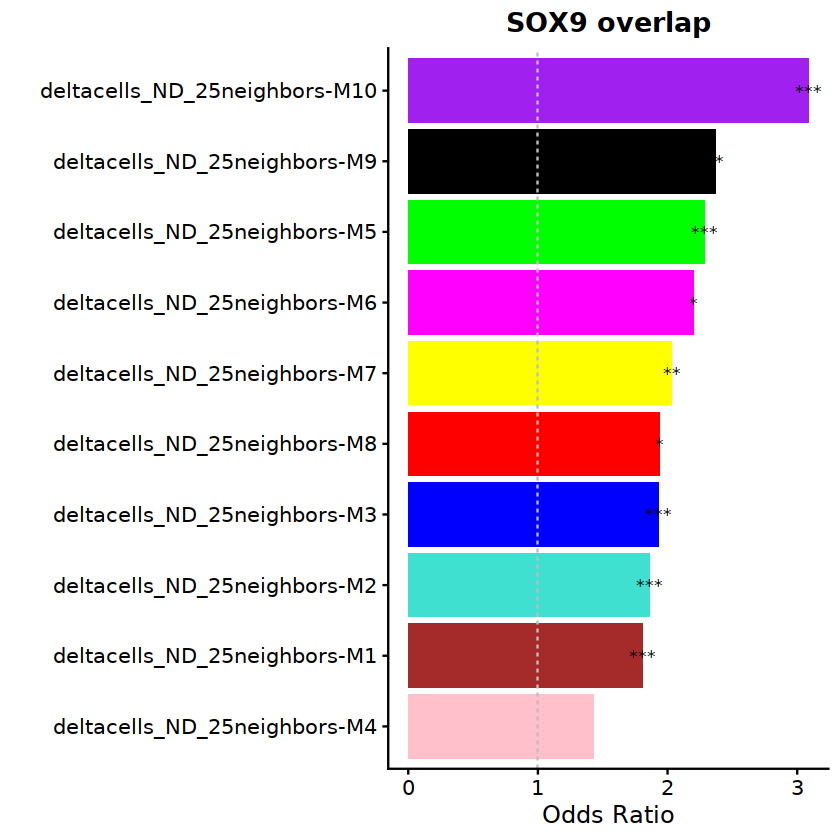

In [14]:
df <- GetMotifOverlap(seurat_obj)

cur_df <- df %>% subset(tf == 'SOX9')

plot_var <- 'odds_ratio'
p <- cur_df %>%
  ggplot(aes(y=reorder(module, odds_ratio), x=odds_ratio)) +
  geom_bar(stat='identity', fill=cur_df$color) +
  geom_vline(xintercept = 1, linetype='dashed', color='gray') +
  geom_text(aes(label=Significance), color='black', size=3.5, hjust='center') +
  ylab('') +
  xlab("Odds Ratio") +
  ggtitle("SOX9 overlap") +
  theme(
    plot.title = element_text(hjust = 0.5)
  )


#png(paste0(fig_dir, 'Sox9_motif_overlap_or.png'), width=3, height=4, units='in', res=400)
p
#dev.off()

In [ ]:
ModuleTFNetwork(
  seurat_obj,
  edge.alpha=0.75,
  cor_thresh = 0.75,
  tf_name = "OLIG1",
  tf_gene_name = "OLIG1",
  tf_x = -7,
  tf_y = -7
)